In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity, BallTree
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from matplotlib.ticker import ScalarFormatter
import os



# File loading


In [10]:
columns = [
    "vehicleId", 
    "lat", 
    "lng", 
    "dateStored", 
    "velocity",
    "odometer", 
    "engineVoltage", 
    "dateStoredHuman", 
    "dateOnlyStoredHuman",    
    "timeOnly",
    "orientation", 
    "seconds_diff", 
    "acceleration",
    "isProblem"
]


input_dir   = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
filename    = "all_vehicle_responses.csv"

In [3]:
# %matplotlib tk

In [11]:
def merge_csv_file(input_dir, filename, columns):
    input_file = os.path.join(input_dir, filename)

    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File '{filename}' not found in directory '{input_dir}'")

    try:
        # Read the CSV while allowing missing columns
        df = pd.read_csv(input_file, usecols=lambda x: x.strip() in columns, encoding='utf-8')
    except Exception as e:
        raise ValueError(f"Error reading '{input_file}': {e}")

    return df



merged_df = merge_csv_file(input_dir, filename, columns)
print(merged_df.head())


FileNotFoundError: File 'all_vehicle_responses.csv' not found in directory '../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv'

Set **Bounding Box** only for **Τρίπολη**

In [5]:
latMin = 37.49764419371479
latMax = 37.56244081620044
lngMin = 22.344992459074458
lngMax = 22.521463853839485


query_filter = 'lat >= ' +str(latMin)+' & lat <= ' + str(latMax) + ' & lng >= ' +str(lngMin)+ ' & lng <= '+str(lngMax)
veh_data_tripoli = merged_df.query( query_filter ).copy(True)
merged_df = veh_data_tripoli

# Data Overview

In [6]:
merged_df.describe

<bound method NDFrame.describe of        vehicleId        lat        lng                  dateStored  velocity  \
89             1  37.510833  22.385710  1970-01-01 00:28:37.682537       0.0   
90             1  37.510603  22.385977  1970-01-01 00:28:37.682540       0.0   
91             1  37.510640  22.385927  1970-01-01 00:28:37.682545       6.0   
92             1  37.510750  22.385907  1970-01-01 00:28:37.682551       7.0   
93             1  37.510877  22.385698  1970-01-01 00:28:37.682557      26.0   
...          ...        ...        ...                         ...       ...   
54493         20  37.531460  22.369768  1970-01-01 00:29:01.259353      71.0   
54494         20  37.531275  22.369473  1970-01-01 00:29:01.259355      74.0   
54495         20  37.531122  22.369195  1970-01-01 00:29:01.259359      67.0   
54496         20  37.531148  22.368967  1970-01-01 00:29:01.259361      66.0   
54497         20  37.531243  22.368705  1970-01-01 00:29:01.259364      66.0   

     

Text(0.5, 1.0, 'Density of problem points on spatial coordinates')

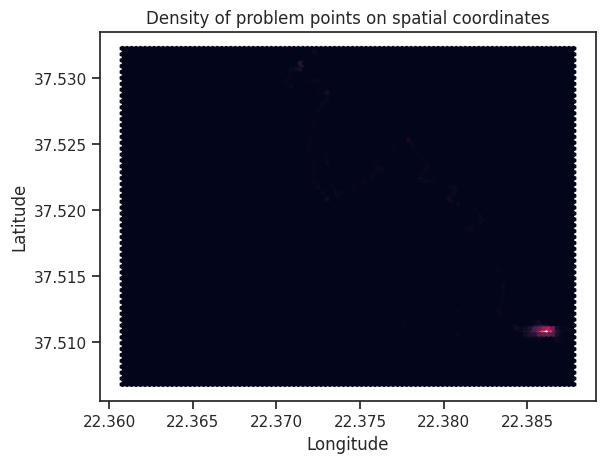

In [7]:
df = merged_df
df_danger = df[df['isProblem'] == 1]
df_danger = df[df['vehicleId'] == 15]


sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#sns.jointplot(x=df_danger['lng'], y=df_danger['lat'], kind="hex", color="#4CB391", ax=ax)
ax.hexbin(x=df_danger['lng'], y=df_danger['lat'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')  # Disable scientific notation


ax.set_title('Density of problem points on spatial coordinates')

In [8]:
df_danger.describe

<bound method NDFrame.describe of        vehicleId        lat        lng                  dateStored  velocity  \
22225         15  37.510750  22.386272  1970-01-01 00:28:48.947727       0.0   
22226         15  37.510823  22.385855  1970-01-01 00:28:48.947728      16.0   
22227         15  37.510872  22.385613  1970-01-01 00:28:48.947739      14.0   
22228         15  37.510858  22.385625  1970-01-01 00:28:48.947748      13.0   
22229         15  37.510848  22.385382  1970-01-01 00:28:48.947753      24.0   
...          ...        ...        ...                         ...       ...   
23737         15  37.523477  22.376433  1970-01-01 00:28:51.008719      33.0   
23738         15  37.524508  22.376960  1970-01-01 00:28:51.008728      51.0   
23739         15  37.525552  22.378802  1970-01-01 00:28:51.008750      14.0   
23740         15  37.525507  22.378780  1970-01-01 00:28:51.008752      10.0   
23741         15  37.525475  22.378782  1970-01-01 00:28:51.008762       0.0   

     

500

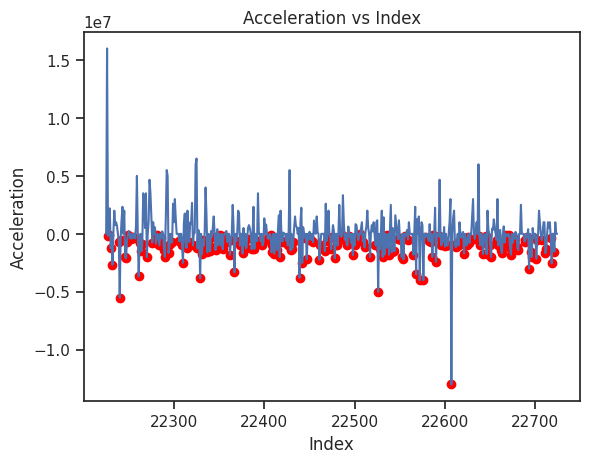

In [9]:
df15 = df[df["vehicleId"] == 15]
df15 = df15.head(500)
df15_problem = df15[df15['isProblem'] == 1]
plt.plot(df15.index, df15['acceleration'])
plt.title('Acceleration vs Index')
plt.ylabel('Acceleration')
plt.xlabel('Index')
plt.scatter(df15_problem.index, df15_problem['acceleration'], color='red')

len(df15)

In [10]:
df_danger[['lng', 'lat']].describe()

,lng,lat
count,1517.000000,1517.000000
mean,22.382625,37.514896
std,0.005373,0.006654
min,22.360795,37.506782
25%,22.380318,37.510752
50%,22.385692,37.510957
75%,22.386168,37.520865
max,22.387758,37.532238


# Clustering

In [11]:
# #### MOCK DATA #####
#
# data = {
#     'lng': np.random.uniform(-180, 180, 200),
#     'lat': np.random.uniform(-90, 90, 200)
# }
# df = pd.DataFrame(data)
# df_danger = df

/tmp/ipykernel_17283/2252399618.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


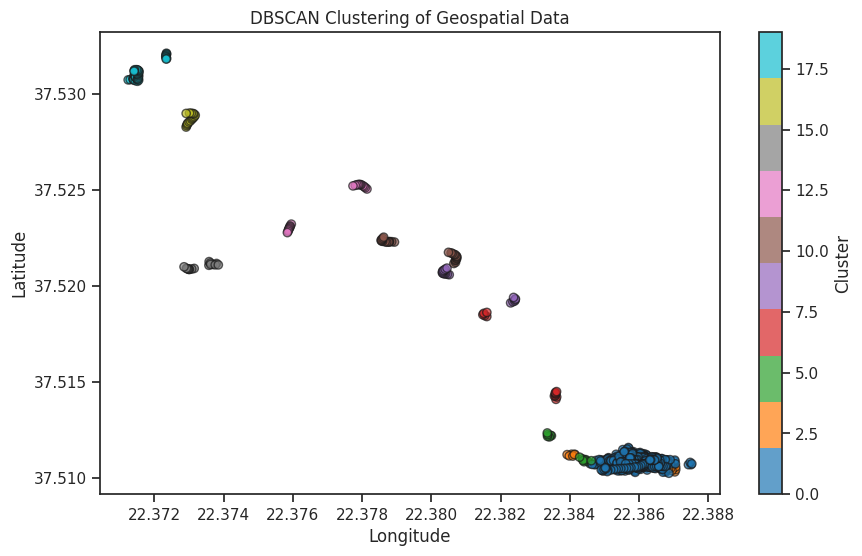

In [12]:
# Extracting the coordinates
coords = df_danger[['lng', 'lat']].values

# Standardizing the data for better clustering performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=4)  # Adjust eps as needed
clusters = dbscan.fit_predict(coords_scaled)

df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


df_danger_cluster = df_danger[df_danger['cluster'] > -1]


# %matplotlib inline
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df_danger_cluster['lng'], df_danger_cluster['lat'], c=df_danger_cluster['cluster'], cmap='tab10', edgecolors='k', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Geospatial Data')
plt.colorbar(label='Cluster')
plt.show()


In [13]:
df_danger.columns

Index(['vehicleId', 'lat', 'lng', 'dateStored', 'velocity', 'odometer',
       'engineVoltage', 'dateStoredHuman', 'dateOnlyStoredHuman', 'timeOnly',
       'orientation', 'acceleration', 'isProblem', 'cluster'],
      dtype='object')

In [14]:
df_danger.describe()

,vehicleId,lat,lng,velocity,odometer,engineVoltage,acceleration,isProblem,cluster
count,1517.0,1517.000000,1517.000000,1517.000000,1517.0,1517.000000,1.517000e+03,1517.000000,1517.000000
mean,15.0,37.514896,22.382625,19.600527,0.0,5.039537,5.353231e+04,0.396177,1.253131
std,0.0,0.006654,0.005373,12.671096,0.0,0.112195,2.417990e+06,0.489263,4.543167
min,15.0,37.506782,22.360795,0.000000,0.0,4.898000,-1.600000e+07,0.000000,-1.000000
25%,15.0,37.510752,22.380318,10.000000,0.0,4.916000,-1.000000e+06,0.000000,-1.000000
50%,15.0,37.510957,22.385692,18.000000,0.0,5.033000,0.000000e+00,0.000000,0.000000
75%,15.0,37.520865,22.386168,28.000000,0.0,5.129000,1.000000e+06,1.000000,0.000000
max,15.0,37.532238,22.387758,55.000000,0.0,5.277000,2.400000e+07,1.000000,19.000000


## Showing convex hulls

/tmp/ipykernel_17283/2620042853.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

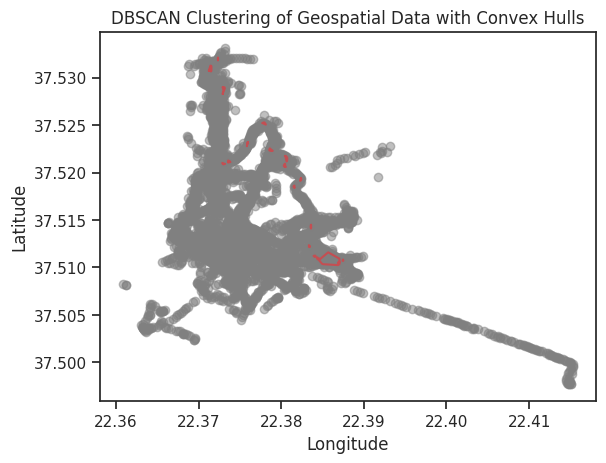

In [15]:
def plot_convex_hulls(df, clusters, normal_df_points):
    # %matplotlib qt

    unique_clusters = set(clusters)
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters

    # Plot points first for colorbar
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', c=[colors(cluster)], s=10)

    plt.scatter(normal_df_points['lng'], normal_df_points['lat'], c='gray', alpha=0.5)

    # Plot Convex Hulls
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the loop
            plt.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], 'r-')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('DBSCAN Clustering of Geospatial Data with Convex Hulls')

    # Create colorbar using scatter points
    plt.colorbar(plt.cm.ScalarMappable(cmap="tab10", norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))),
                 label='Cluster')

    #plt.legend()
    plt.show()


plot_convex_hulls(df_danger_cluster, clusters, df[df['isProblem'] == 0])


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def get_largest_cluster_bounding_box(df, cluster_column='cluster', coord_columns=['lng', 'lat']):
    # Get unique clusters
    unique_clusters = df[cluster_column].unique()

    largest_area = 0
    largest_cluster = None
    largest_hull_points = None

    # Iterate through clusters to find the one with the largest area
    for cluster in unique_clusters:
        if cluster == -1:  # Skip noise points
            continue

        # Get the points for the current cluster
        cluster_points = df[df[cluster_column] == cluster][coord_columns].values

        # Compute the convex hull
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            hull_area = hull.volume  # For 2D, 'volume' is the area of the convex hull

            if hull_area > largest_area:
                largest_area = hull_area
                largest_cluster = cluster
                largest_hull_points = hull_points

    # If no clusters found or all were noise, return None
    if largest_cluster is None:
        return None

    # Create a Polygon object from the convex hull
    polygon = Polygon(largest_hull_points)

    # Get the bounding box (min and max lat, lng)
    min_lng, min_lat, max_lng, max_lat = polygon.bounds

    return {
        'largest_cluster': largest_cluster,
        'bounding_box': {
            'min_lng': min_lng,
            'min_lat': min_lat,
            'max_lng': max_lng,
            'max_lat': max_lat
        }
    }

# Example usage:
# Assuming df_danger is the DataFrame with the 'cluster' column, 'lng', and 'lat'
result = get_largest_cluster_bounding_box(df_danger)
if result:
    print(f"Largest Cluster: {result['largest_cluster']}")
    print(f"Bounding Box: {result['bounding_box']}")
else:
    print("No valid clusters found.")


Largest Cluster: 0
Bounding Box: {'min_lng': 22.384585, 'min_lat': 37.5102516, 'max_lng': 22.3870483, 'max_lat': 37.51159}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt# Collect coords into list
import requests

import json
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-1"="DE"][admin_level=2];
(node["amenity"="biergarten"](area);way["amenity"="biergarten"](area);rel["amenity"="biergarten"](area);
);
out center;
"""
response = requests.get(overpass_url,
                        params={'data': overpass_query})
data = response.json()

coords = []
for element in data['elements']:
    if element['type'] == 'node':
        lon = element['lon']
        lat = element['lat']
        coords.append((lon, lat))
    elif 'center' in element:
        lon = element['center']['lon']
        lat = element['center']['lat']
        coords.append((lon, lat))# Convert coordinates into numpy array


X = np.array(coords)

plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Biergarten in Germany')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define bounding box (min_lon, min_lat, max_lon, max_lat)
bbox = (-122.523, 37.704, -122.354, 37.833)  # Example: San Francisco

# Example coordinate points (replace with real data)
coords = [
    (-122.45, 37.75),
    (-122.40, 37.78),
    (-122.48, 37.73)
]

# Convert to numpy array
X = np.array(coords)

# Create a figure with Cartopy
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection": ccrs.PlateCarree()})

# Set the map extent to the bounding box
ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]], crs=ccrs.PlateCarree())

# Add roads and features
ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAKES, color="blue", alpha=0.3)
ax.add_feature(cfeature.RIVERS, color="blue", alpha=0.3)

# Plot points
ax.scatter(X[:, 0], X[:, 1], color="red", marker="o", label="Points")

# Labels and title
ax.set_title("Custom Location Map")
ax.legend()

# Save the output
output_filename = "local_map.png"
plt.savefig(output_filename, dpi=300)
plt.show()

print(f"Map with points saved as {output_filename}")


/home/georger/anaconda3/envs/ArcGIS/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Map with points saved as local_map.png
